Perform statistical analyses of metrics computed in 3A.

In [1]:
%matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size


# EXPT = 'CL_360_LOWFLOW_ACV'
EXPT = 'CL_180_HighFlow_ACV'
# EXPT = 'CL_360_LOWFLOW_ACV_1'
# EXPT = 'CL_360_LOWFLOW_ACV_2'

DATA_DIR = os.path.join('data_', EXPT)
SAVE_DIR = 'data_/_RESULTS/ODOR_TRACKING'
SAVE_DIR_STATS = 'data_/_RESULTS/ODOR_TRACKING_STATS'

FACTORS = ['None', 'h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_v_7_10', 'd_h_7_10']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5', 'ForVel', 'AngVel', 'AbsAngVel', 'AbsHeading', 'Motion']

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

trials = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'AbsHeading', 'Motion']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        
        for start, stop in zip(starts, stops):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor
        
        trials.append(trial)

# Save odor-triggered data matrices

In [3]:
DT = 0.1
T_WDW_OTA = [-10., 20.]  # time window for odor-triggered avg
VARS_OTA = [
    'G2', 'G3', 'G4', 'G5',
    'DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5',
    'AbsHeading', 'DeltaAbsHeading',
    'ForVel', 'DeltaForVel'
]

t_ota = np.arange(*T_WDW_OTA, DT)
wdw_d = [None, None]
wdw_d[0] = int(round(T_WDW_OTA[0]/DT))
wdw_d[1] = wdw_d[0] + len(t_ota)

df_blank = pd.DataFrame(columns=['PulseID', 'Trial', 'PulseCounter', 'Include'] + list(t_ota))


# loop over control odor offsets (0 = no offset, true odor times used)
for ctl_offset in [0, -10, -20, -30]:
    
    sys.stdout.write('CTL_OFFSET = {}: '.format(ctl_offset))
    odor_trig = {k.upper(): df_blank.copy() for k in VARS_OTA}
    
    # loop over trials
    p_id = 0

    for trial, data_u_ in data_u.items():
        sys.stdout.write('|')
        
        # loop over odor pulses
        pulses = d_odor[trial]

        starts = pulses[odor_cols[0]] + ctl_offset
        stops = pulses[odor_cols[1]] + ctl_offset
        includes_binary = pulses[odor_cols[2]]
        includes = ['Include' if x else 'Exclude' for x in includes_binary ]

        for ctr, (start, stop, include) in enumerate(zip(starts, stops, includes)):
            sys.stdout.write('.')
            # get time window for data selection
            t_idx = int(round(start/DT))
            t_idx_0 = t_idx + wdw_d[0]
            t_idx_1 = t_idx + wdw_d[1]

            g2 = data_u_['G2'][t_idx_0:t_idx_1]
            g3 = data_u_['G3'][t_idx_0:t_idx_1]
            g4 = data_u_['G4'][t_idx_0:t_idx_1]
            g5 = data_u_['G5'][t_idx_0:t_idx_1]

            for_vel = data_u_['ForVel'][t_idx_0:t_idx_1]
            abs_heading = data_u_['AbsHeading'][t_idx_0:t_idx_1]

            odor_trig['G2'].loc[p_id] = [p_id, trial, ctr, include] + list(g2)
            odor_trig['G3'].loc[p_id] = [p_id, trial, ctr, include] + list(g3)
            odor_trig['G4'].loc[p_id] = [p_id, trial, ctr, include] + list(g4)
            odor_trig['G5'].loc[p_id] = [p_id, trial, ctr, include] + list(g5)

            odor_trig['FORVEL'].loc[p_id] = [p_id, trial, ctr, include] + list(for_vel)
            odor_trig['ABSHEADING'].loc[p_id] = [p_id, trial, ctr, include] + list(abs_heading)

            # get computed data features

            ## neural dff/f
            f0_g2 = np.nanmean(g2)
            f0_g3 = np.nanmean(g3)
            f0_g4 = np.nanmean(g4)
            f0_g5 = np.nanmean(g5)

            dff_g2 = (g2 - f0_g2) / f0_g2
            dff_g3 = (g3 - f0_g3) / f0_g3
            dff_g4 = (g4 - f0_g4) / f0_g4
            dff_g5 = (g5 - f0_g5) / f0_g5

            odor_trig['DFF0G2'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g2)
            odor_trig['DFF0G3'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g3)
            odor_trig['DFF0G4'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g4)
            odor_trig['DFF0G5'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g5)

            ## behavior delta
            for_vel_0 = np.nanmean(for_vel[t_ota < 0])
            abs_heading_0 = np.nanmean(abs_heading[t_ota < 0])

            delta_for_vel = for_vel - for_vel_0
            delta_abs_heading = abs_heading - abs_heading_0

            odor_trig['DELTAFORVEL'].loc[p_id] = [p_id, trial, ctr, include] + list(delta_for_vel)
            odor_trig['DELTAABSHEADING'].loc[p_id] = [p_id, trial, ctr, include] + list(delta_abs_heading)

            p_id += 1

    # save results
    for k, df_save in odor_trig.items():
        if ctl_offset == 0:
            fn = '{}_ODOR_TRIG_{}.csv'.format(EXPT, k)
        else:
            fn = '{}_ODOR_TRIG_{}_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, k, ctl_offset)
        df_save.to_csv(os.path.join(SAVE_DIR, fn), na_rep='NaN', index=False)
        
    sys.stdout.write('\n')

CTL_OFFSET = 0: |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.
CTL_OFFSET = -10: |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.
CTL_OFFSET = -20: |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.
CTL_OFFSET = -30: |.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.


# Full neural-heading cross-correlation matrices

In [4]:
VARS = ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5', 'FORVEL', 'ABSHEADING']

labels = {
    'DFF0G2': 'G2 DF/F0',
    'DFF0G3': 'G3 DF/F0',
    'DFF0G4': 'G4 DF/F0',
    'DFF0G5': 'G5 DF/F0',
    'FORVEL': 'FOR VEL',
    'ABSHEADING': 'ABS HEAD',
}

# loop over false odor times
for ctl_offset in [0, -10, -20, -30]:
    
    # load all data
    dfs = {}
    for var in VARS:
        if not ctl_offset:  # true odor pulses
            fn = '{}_ODOR_TRIG_{}.csv'.format(EXPT, var)
        else:
            fn = '{}_ODOR_TRIG_{}_FALSE_ODOR_OFFSET_{}.csv'.format(EXPT, var, ctl_offset)
            
        df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
        dfs[var] = df  # [df['Include'] == 'Include']

    t = dfs[VARS[0]].columns[3:].astype(float)

    rs_all = {}
    ps_all = {}
    ns_all = {}

    # cross correlations
    ## loop over behavs
    for behav in ['FORVEL', 'ABSHEADING']:

        # get behav matrix
        behav_mat = np.array(dfs[behav])[:, 3:].astype(float)

        # loop over DANs
        for gx in ['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5']:

            # get DAN mat
            gx_mat = np.array(dfs[gx])[:, 3:].astype(float)

            # compute timepoint-by-timepoint correlations
            rs = np.nan * np.zeros((len(t), len(t)))
            ps = np.nan * np.zeros((len(t), len(t)))
            ns = np.nan * np.zeros((len(t), len(t)), dtype=int)

            for b_ctr, behav_t in enumerate(behav_mat.T):
                for g_ctr, gx_t in enumerate(gx_mat.T):

                    valid = (~np.isnan(behav_t)) & (~np.isnan(gx_t))

                    r, p = stats.pearsonr(behav_t[valid], gx_t[valid])
                    n = valid.sum()

                    rs[b_ctr, g_ctr] = r
                    ps[b_ctr, g_ctr] = p
                    ns[b_ctr, g_ctr] = n

            rs_all[(behav, gx)] = rs
            ps_all[(behav, gx)] = ps
            ns_all[(behav, gx)] = ns

    # autocorrelations
    for k in VARS:

        # get data matrix
        mat = np.array(dfs[k])[:, 3:].astype(float)

        # compute timepoint-by-timepoint correlations
        rs = np.nan * np.zeros((len(t), len(t)))
        ps = np.nan * np.zeros((len(t), len(t)))
        ns = np.nan * np.zeros((len(t), len(t)), dtype=int)

        for i, k_t_i in enumerate(mat.T):
            for j, k_t_j in enumerate(mat.T):

                valid = (~np.isnan(k_t_i)) & (~np.isnan(k_t_j))

                r, p = stats.pearsonr(k_t_i[valid], k_t_j[valid])
                n = valid.sum()

                rs[i, j] = r
                ps[i, j] = p
                ns[i, j] = n

        rs_all[(k, k)] = rs
        ps_all[(k, k)] = ps
        ns_all[(k, k)] = ns
        
    # behav-behav xcor
    forvel_mat = np.array(dfs['FORVEL'])[:, 3:].astype(float)
    abshead_mat = np.array(dfs['ABSHEADING'])[:, 3:].astype(float)
    
    rs = np.nan * np.zeros((len(t), len(t)))
    ps = np.nan * np.zeros((len(t), len(t)))
    ns = np.nan * np.zeros((len(t), len(t)), dtype=int)

    for fv_ctr, fv_t in enumerate(forvel_mat.T):
        for ah_ctr, ah_t in enumerate(mat.T):

            valid = (~np.isnan(fv_t)) & (~np.isnan(ah_t))

            r, p = stats.pearsonr(fv_t[valid], ah_t[valid])
            n = valid.sum()

            rs[fv_ctr, ah_ctr] = r
            ps[fv_ctr, ah_ctr] = p
            ns[fv_ctr, ah_ctr] = n

    rs_all[('FORVEL', 'ABSHEADING')] = rs
    ps_all[('FORVEL', 'ABSHEADING')] = ps
    ns_all[('FORVEL', 'ABSHEADING')] = ns
        
    # save files
    ## loop over all variable pairs
    for k, v in rs_all:
        rs = rs_all[(k, v)]
        ps = ps_all[(k, v)]
        ns = ns_all[(k, v)]
        
        if not ctl_offset:
            sfx = '{}_{}'.format(k, v)
        else:
            sfx = '{}_{}_FALSE_ODOR_OFFSET_{}'.format(k, v, ctl_offset)
        
        # convert to df
        df_r = pd.DataFrame(rs, index=t, columns=t)
        df_p = pd.DataFrame(ps, index=t, columns=t)
        df_n = pd.DataFrame(ns, index=t, columns=t)
        
        # save
        df_r.to_csv(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_R_{}.csv'.format(EXPT, sfx)))
        df_p.to_csv(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_P_{}.csv'.format(EXPT, sfx)))
        df_n.to_csv(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_N_{}.csv'.format(EXPT, sfx)))

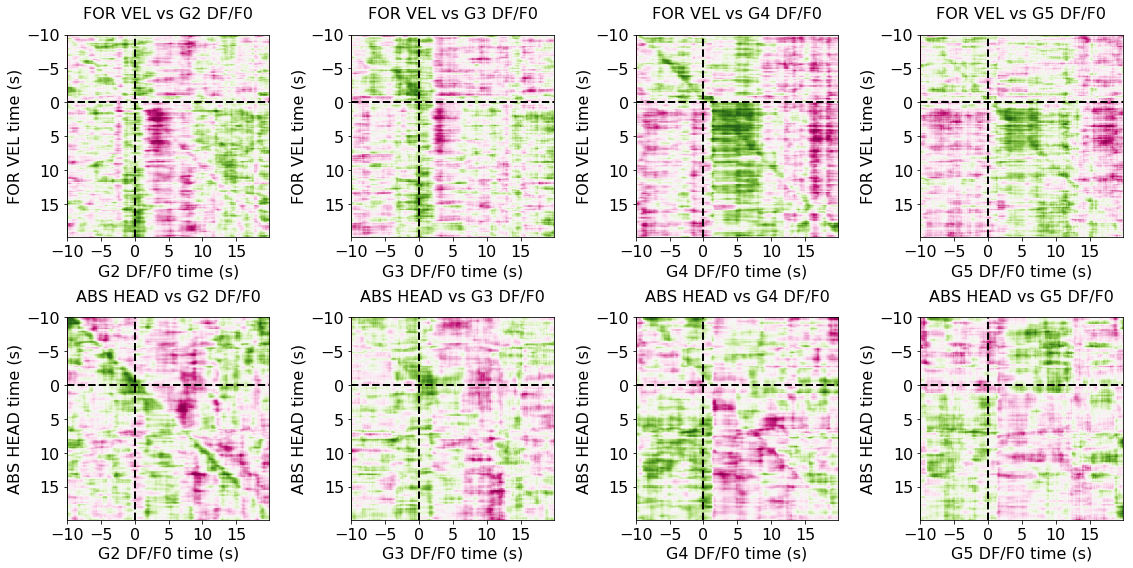

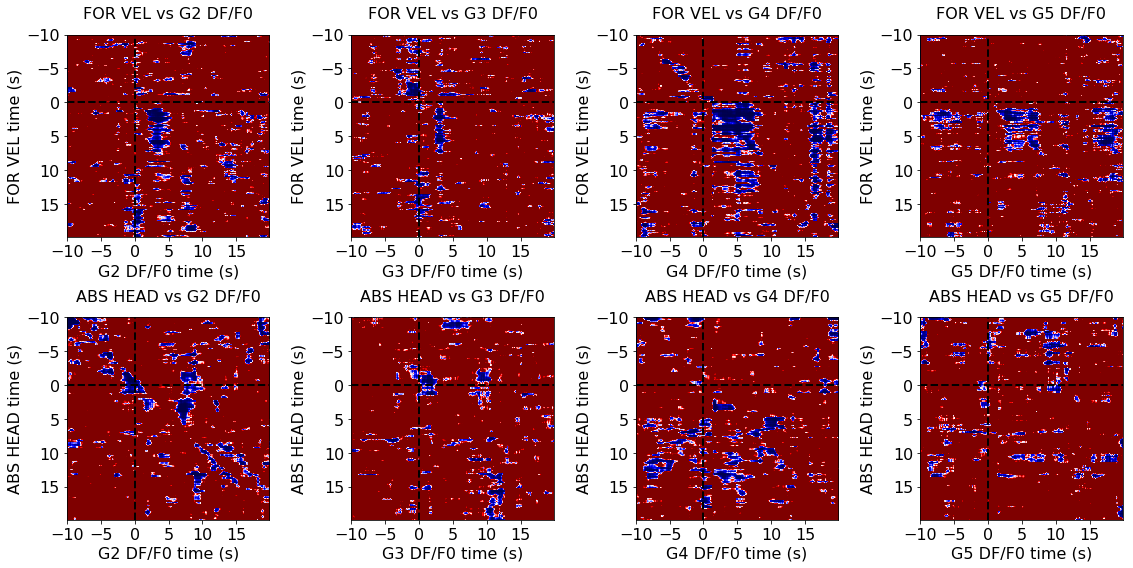

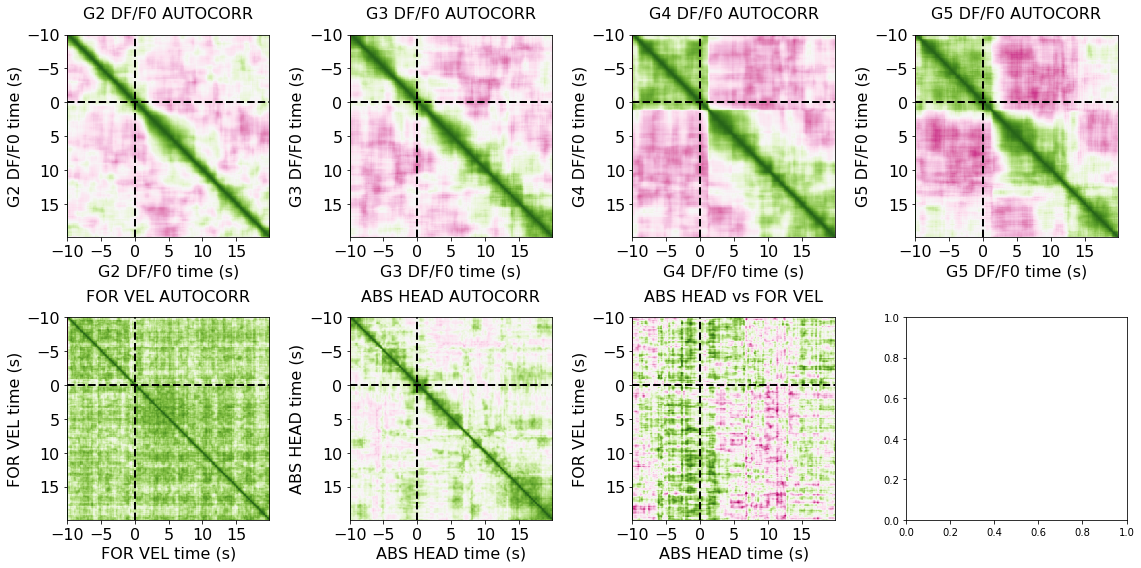

In [5]:
ctl_offset = 0

sfx = '_FALSE_ODOR_OFFSET_{}'.format(ctl_offset) if ctl_offset else ''

# cross correlations
fig_r, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
    for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):
        
        fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
        df_r = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))
        
        ax.matshow(
            df_r, extent=[t.min(), t.max(), t.max(), t.min()],
            vmin=-.5, vmax=.5, cmap='PiYG')
        
        ax.axhline(0, color='k', lw=2, ls='--')
        ax.axvline(0, color='k', lw=2, ls='--')
        
        ax.xaxis.tick_bottom()
        
        ax.set_xlabel('{} time (s)'.format(labels[gx]))
        ax.set_ylabel('{} time (s)'.format(labels[behav]))
        
        ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))
        
        set_font_size(ax, 16)
        
# p-values
fig_p, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
    for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):
        
        fn = '{}_ODOR_TRIG_XCORR_P_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
        df_p = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))
        
        ax.matshow(
            df_p, extent=[t.min(), t.max(), t.max(), t.min()],
            vmin=0, vmax=.1, cmap='seismic')
        
        ax.axhline(0, color='k', lw=2, ls='--')
        ax.axvline(0, color='k', lw=2, ls='--')
        
        ax.xaxis.tick_bottom()
        
        ax.set_xlabel('{} time (s)'.format(labels[gx]))
        ax.set_ylabel('{} time (s)'.format(labels[behav]))
        
        ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))
        
        set_font_size(ax, 16)
        
# autocorrs
fig_a, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for k, ax in zip(VARS, axs.flat):
    
    fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, k, k, sfx)
    df_a = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))
    
    ax.matshow(
        df_a, extent=[t.min(), t.max(), t.max(), t.min()],
        vmin=-1, vmax=1, cmap='PiYG')
        
    ax.axhline(0, color='k', lw=2, ls='--')
    ax.axvline(0, color='k', lw=2, ls='--')

    ax.xaxis.tick_bottom()

    ax.set_xlabel('{} time (s)'.format(labels[k]))
    ax.set_ylabel('{} time (s)'.format(labels[k]))

    ax.set_title('{} AUTOCORR'.format(labels[k]))

    set_font_size(ax, 16)
    
# xcor of forvel and abshead
fn = '{}_ODOR_TRIG_XCORR_R_FORVEL_ABSHEADING{}.csv'.format(EXPT, sfx)
df_x = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))

ax = axs[1, 2]

ax.matshow(
    df_x, extent=[t.min(), t.max(), t.max(), t.min()],
    vmin=-.5, vmax=.5, cmap='PiYG')

ax.axhline(0, color='k', lw=2, ls='--')
ax.axvline(0, color='k', lw=2, ls='--')

ax.xaxis.tick_bottom()

ax.set_xlabel('{} time (s)'.format(labels['ABSHEADING']))
ax.set_ylabel('{} time (s)'.format(labels['FORVEL']))

ax.set_title('{} vs {}'.format(labels['ABSHEADING'], labels['FORVEL']))

set_font_size(ax, 16)
    
fig_r.savefig(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_R_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
fig_p.savefig(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_P_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
fig_a.savefig(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_ACORR_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))

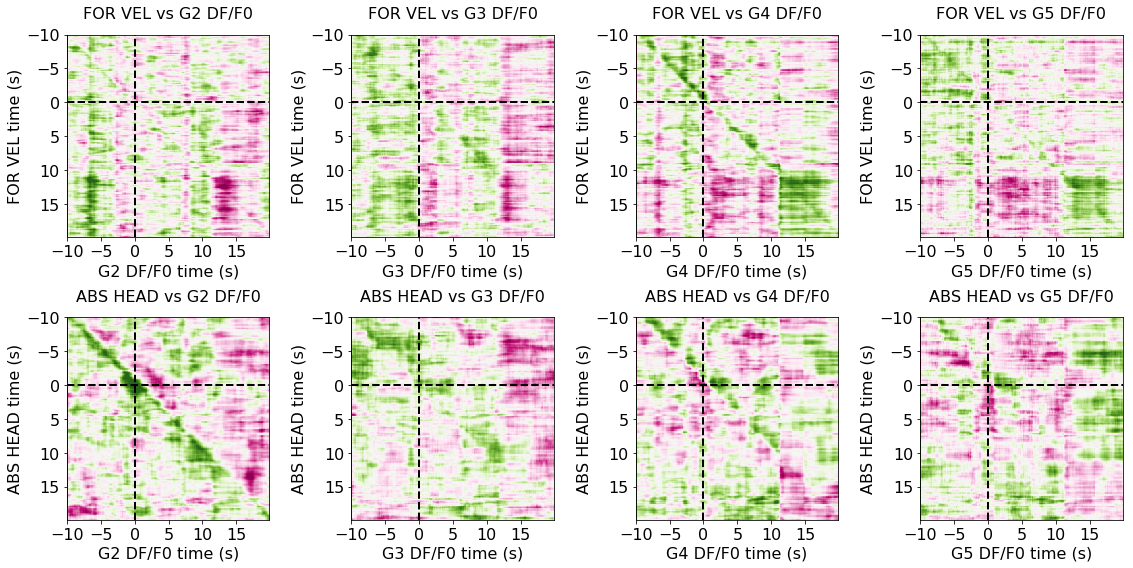

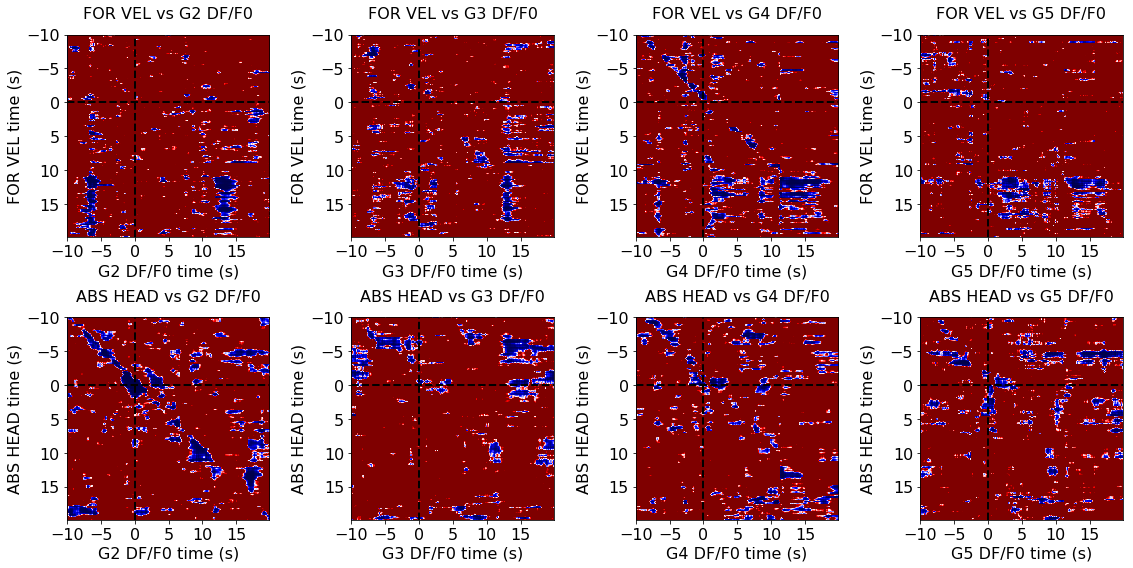

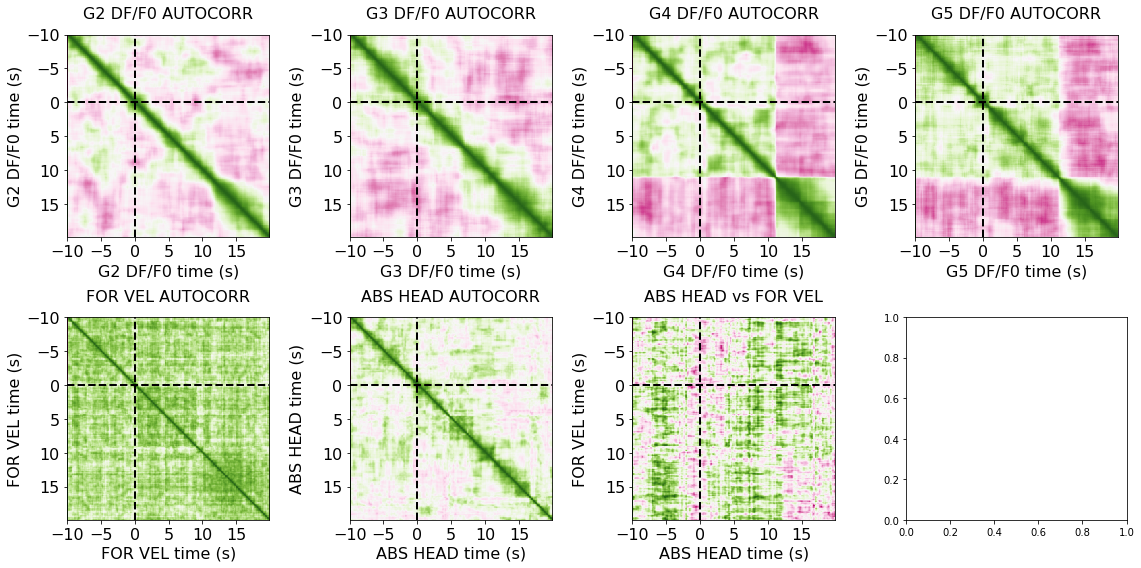

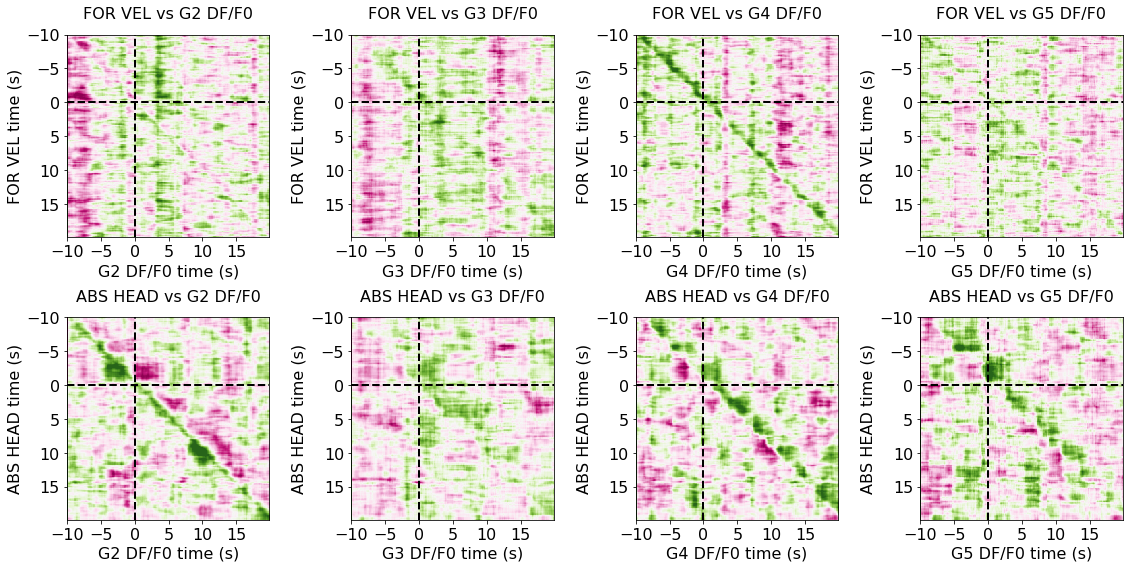

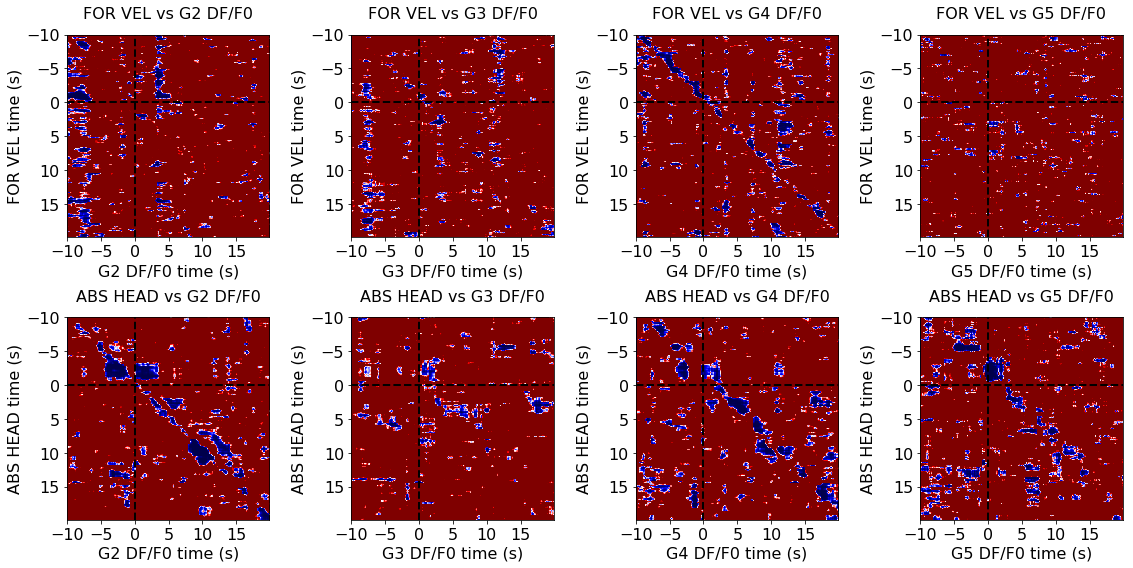

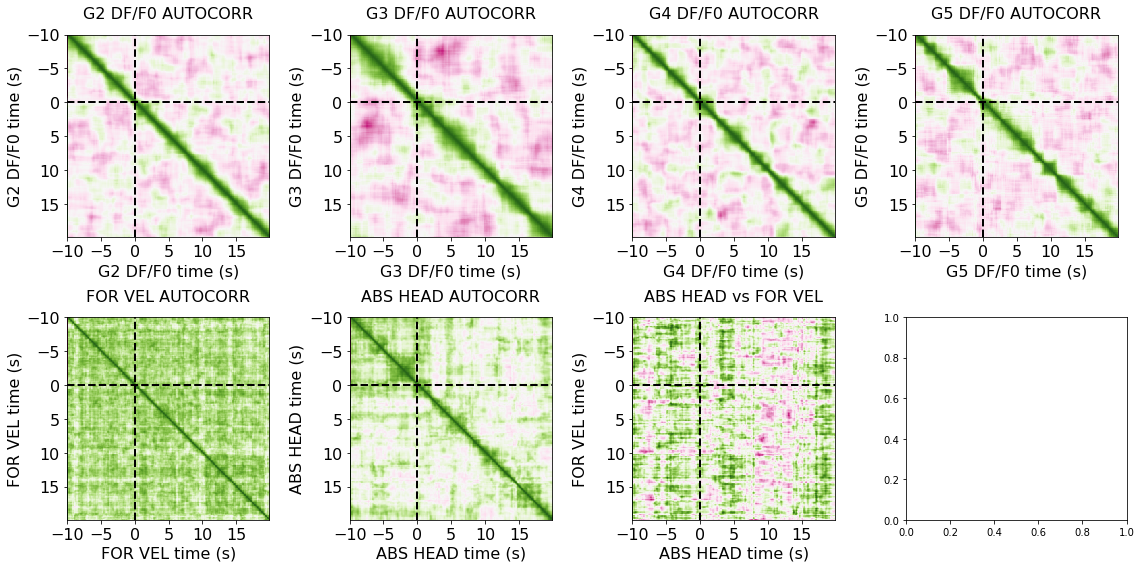

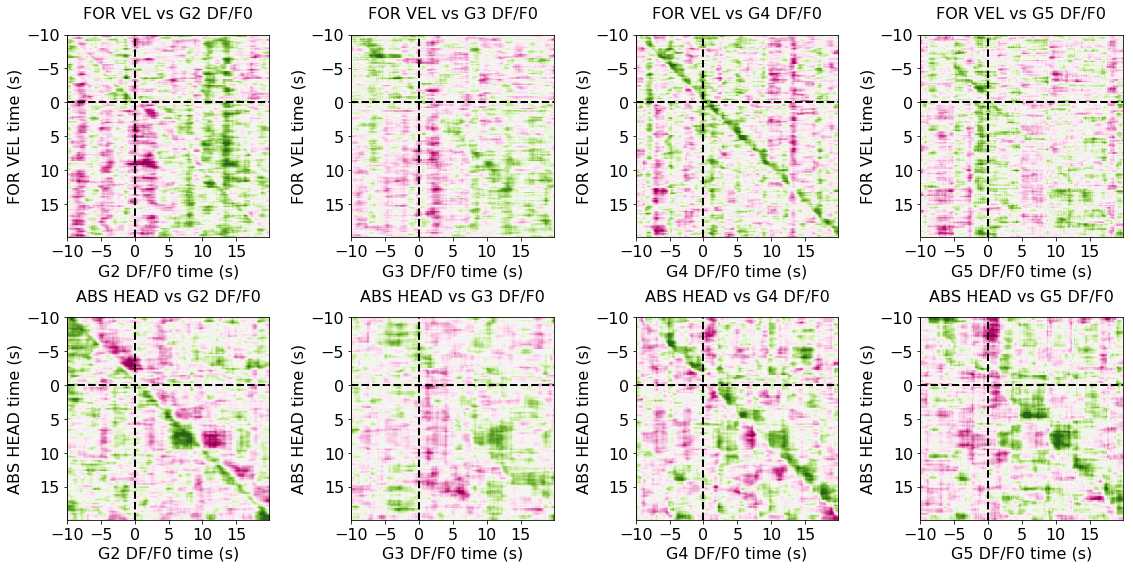

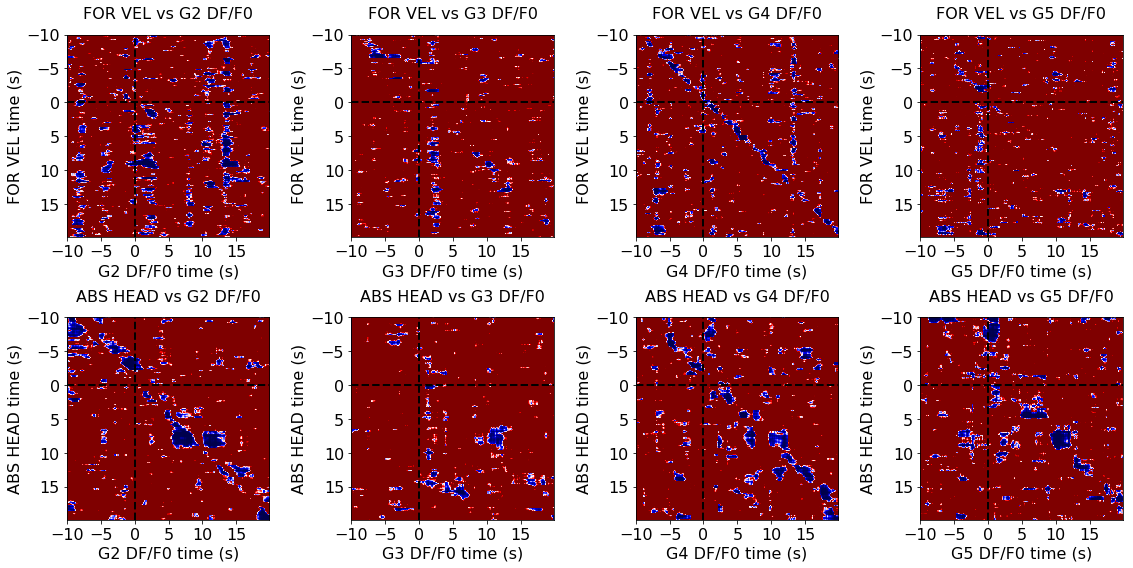

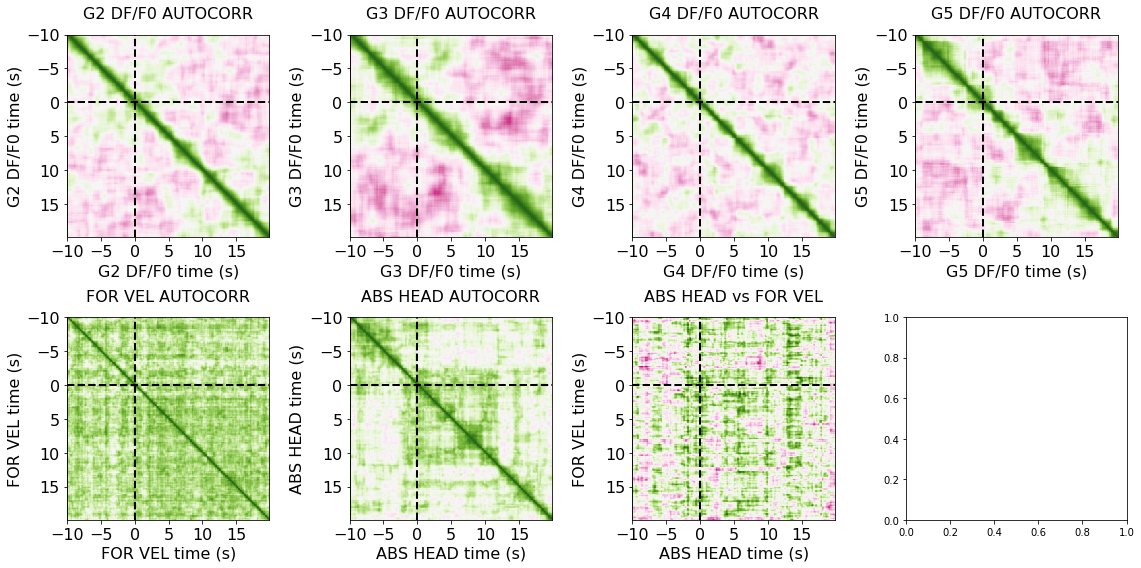

In [6]:
for ctl_offset in [-10, -20, -30]:

    sfx = '_FALSE_ODOR_OFFSET_{}'.format(ctl_offset) if ctl_offset else ''

    # cross correlations
    fig_r, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

    for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
        for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):

            fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
            df_r = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))

            ax.matshow(
                df_r, extent=[t.min(), t.max(), t.max(), t.min()],
                vmin=-.5, vmax=.5, cmap='PiYG')

            ax.axhline(0, color='k', lw=2, ls='--')
            ax.axvline(0, color='k', lw=2, ls='--')

            ax.xaxis.tick_bottom()

            ax.set_xlabel('{} time (s)'.format(labels[gx]))
            ax.set_ylabel('{} time (s)'.format(labels[behav]))

            ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))

            set_font_size(ax, 16)

    # p-values
    fig_p, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

    for behav, ax_row in zip(['FORVEL', 'ABSHEADING'], axs):
        for gx, ax in zip(['DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5'], ax_row):

            fn = '{}_ODOR_TRIG_XCORR_P_{}_{}{}.csv'.format(EXPT, behav, gx, sfx)
            df_p = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))

            ax.matshow(
                df_p, extent=[t.min(), t.max(), t.max(), t.min()],
                vmin=0, vmax=.1, cmap='seismic')

            ax.axhline(0, color='k', lw=2, ls='--')
            ax.axvline(0, color='k', lw=2, ls='--')

            ax.xaxis.tick_bottom()

            ax.set_xlabel('{} time (s)'.format(labels[gx]))
            ax.set_ylabel('{} time (s)'.format(labels[behav]))

            ax.set_title('{} vs {}'.format(labels[behav], labels[gx]))

            set_font_size(ax, 16)

    # autocorrs
    fig_a, axs = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

    for k, ax in zip(VARS, axs.flat):

        fn = '{}_ODOR_TRIG_XCORR_R_{}_{}{}.csv'.format(EXPT, k, k, sfx)
        df_a = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))

        ax.matshow(
            df_a, extent=[t.min(), t.max(), t.max(), t.min()],
            vmin=-1, vmax=1, cmap='PiYG')

        ax.axhline(0, color='k', lw=2, ls='--')
        ax.axvline(0, color='k', lw=2, ls='--')

        ax.xaxis.tick_bottom()

        ax.set_xlabel('{} time (s)'.format(labels[k]))
        ax.set_ylabel('{} time (s)'.format(labels[k]))

        ax.set_title('{} AUTOCORR'.format(labels[k]))

        set_font_size(ax, 16)
        
    # xcor of forvel and abshead
    fn = '{}_ODOR_TRIG_XCORR_R_FORVEL_ABSHEADING{}.csv'.format(EXPT, sfx)
    df_x = pd.read_csv(os.path.join(SAVE_DIR_STATS, fn))

    ax = axs[1, 2]

    ax.matshow(
        df_x, extent=[t.min(), t.max(), t.max(), t.min()],
        vmin=-.5, vmax=.5, cmap='PiYG')

    ax.axhline(0, color='k', lw=2, ls='--')
    ax.axvline(0, color='k', lw=2, ls='--')

    ax.xaxis.tick_bottom()

    ax.set_xlabel('{} time (s)'.format(labels['ABSHEADING']))
    ax.set_ylabel('{} time (s)'.format(labels['FORVEL']))

    ax.set_title('{} vs {}'.format(labels['ABSHEADING'], labels['FORVEL']))

    set_font_size(ax, 16)
        
    fig_r.savefig(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_R_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
    fig_p.savefig(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_XCORR_P_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))
    fig_a.savefig(os.path.join(SAVE_DIR_STATS, '{}_ODOR_TRIG_ACORR_BEHAV_DAN{}.pdf'.format(EXPT, sfx)))